# Face Recognition Model

## Method 1:
<h3>(Training the Model to classify the images)</h3>

Importing required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
# import seaborn as sns
# import matplotlib.image as mpimg
# import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam


Loading and preprocessing the data

In [3]:
# Splitting the data into training and testing
train_path = '/kaggle/input/pins-face-recogntion-dataset/splitted_dataset/train'
test_path = '/kaggle/input/pins-face-recogntion-dataset/splitted_dataset/test'

In [4]:
images_size = 160
batch_size = 16 # Number of images to process at a time

In [5]:
# Checking for invalid or corrupted images

from tqdm import tqdm  # Optional: tqdm for progress bar

problematic_files = []

for root, dirs, files in os.walk('/kaggle/input/pins-face-recogntion-dataset/splitted_dataset'):
    for file in tqdm(files, desc="Checking Images"):
        try:
            image = Image.open(os.path.join(root, file))
            image.verify()  # Attempt to open and verify the image
        except (IOError, SyntaxError) as e:
            print(f"Problematic Image: {os.path.join(root, file)}")
            problematic_files.append(os.path.join(root, file))

print("Problematic files:", problematic_files)

Checking Images: 0it [00:00, ?it/s]
Checking Images: 0it [00:00, ?it/s]
Checking Images: 100%|██████████| 30/30 [00:00<00:00, 114.22it/s]
Checking Images: 0it [00:00, ?it/s]
Checking Images: 100%|██████████| 120/120 [00:00<00:00, 123.22it/s]

Problematic files: []


Data augmentation along with preprocessing

In [6]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1] (Normalise)
    rotation_range=30,              # rotation within 30 degrees
    width_shift_range=0.3,          # horizontal shift by 30% of image width
    height_shift_range=0.3,         # vertical shift by 30% of image height
    horizontal_flip=True,           # horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data directory
    target_size=(images_size, images_size),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)

Found 14384 images belonging to 105 classes.


In [8]:
# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [9]:
# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')

Found 3150 images belonging to 105 classes.


Displaying images

In [10]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(15, 15))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),9))):
        plt.subplot(3, 3, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

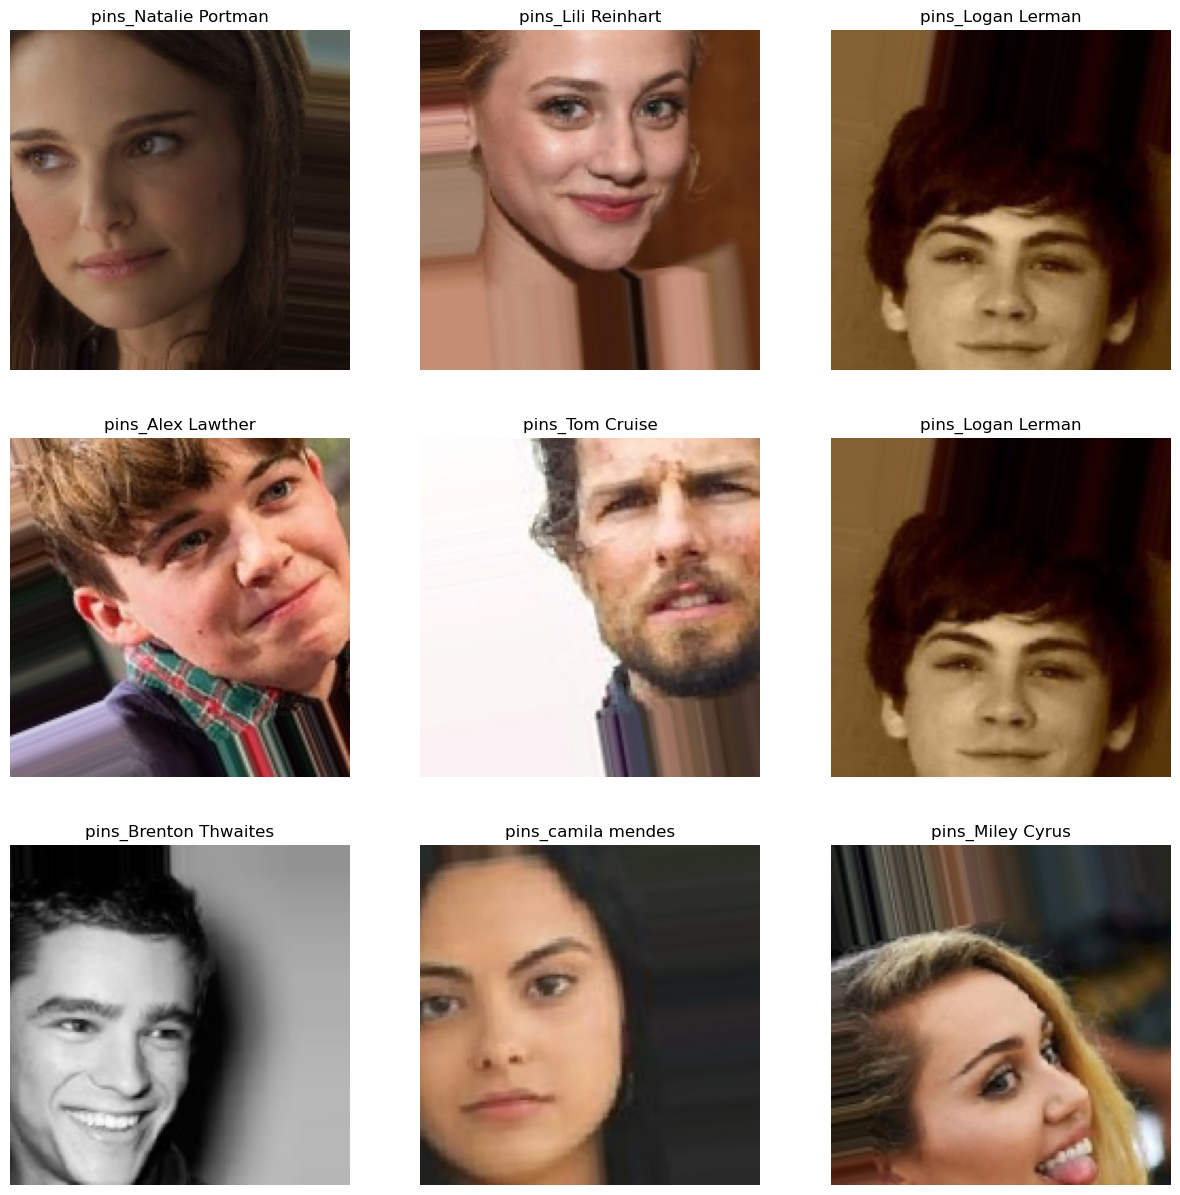

In [11]:
Show_Images(train_generator)

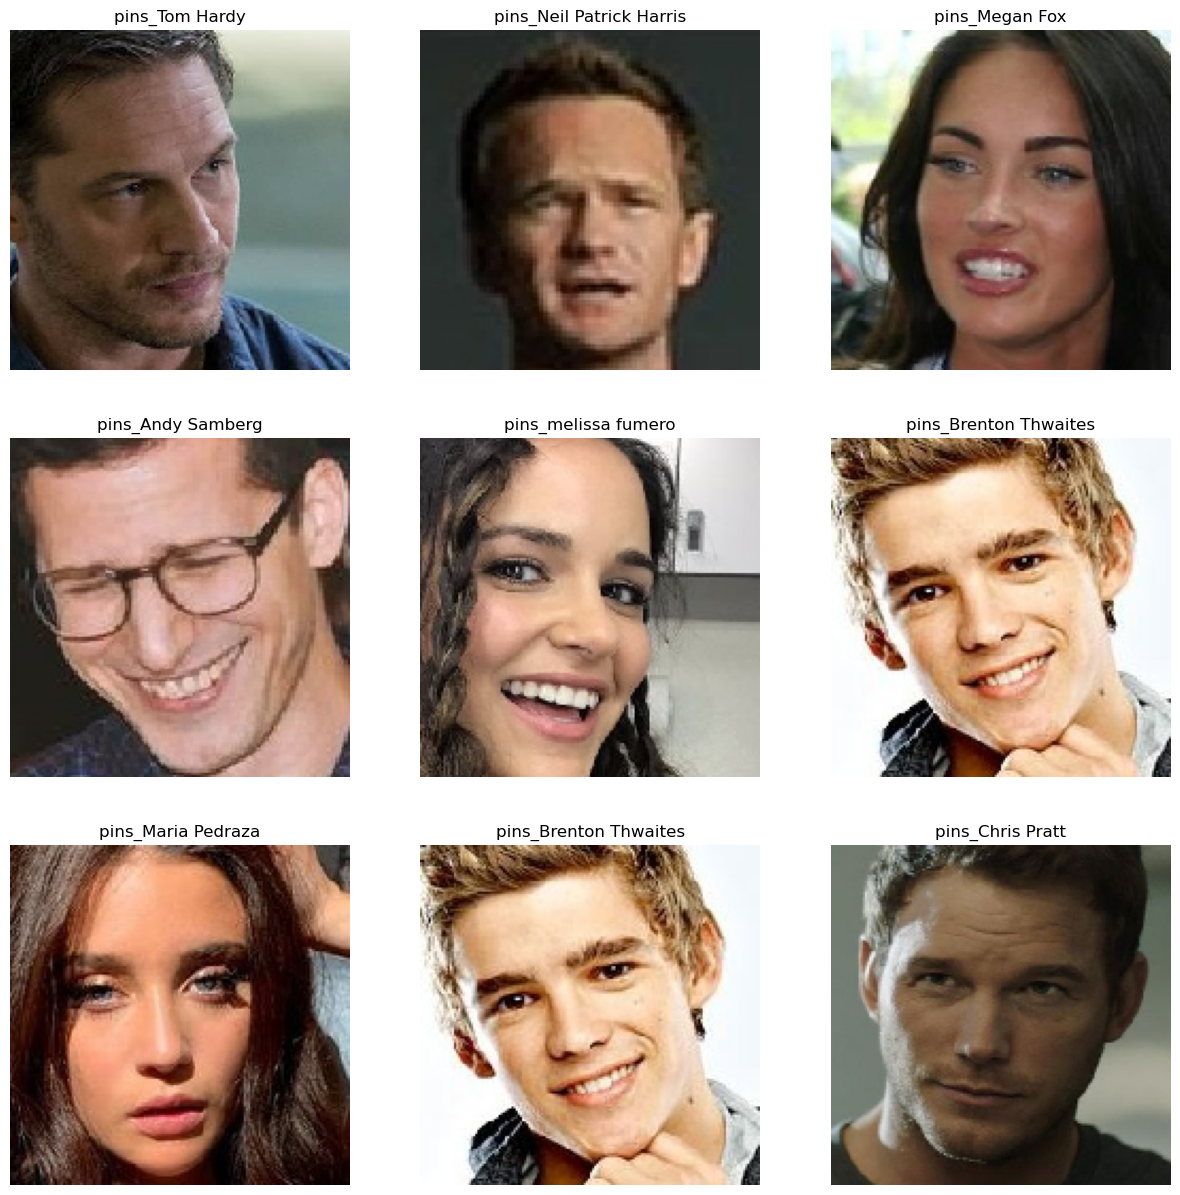

In [12]:
Show_Images(test_generator)

Configuring Learning Rate Scheduler callback function with Exponential Decay

In [13]:
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps to wait before decaying the learning rate
    decay_rate=0.5,              # Rate by which the learning rate decreases
)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)

In [14]:
from keras.callbacks import LearningRateScheduler

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)

Configuring Early Stopping callback function

In [15]:
# Configuring the Early Stopping callback
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5,      # how many epochs to wait before stopping
    restore_best_weights=True,
)

Configuring Learing rate reduction callback function

In [16]:
# Configuring the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced 
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

Model Building

In [26]:
# Loading pretrained model as base model
base_model = keras.models.load_model('/kaggle/input/facenet-keras/facenet_keras.h5')
model = tf.keras.models.Sequential([
    base_model,
    # customizing the model 
    layers.Dense(512,activation='relu'), 
    layers.Dense(105,activation='softmax'), # Classify images into 105 classes using probability distribution
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v1 (Functi  (None, 128)              22808144  
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 105)               53865     
                                                                 
Total params: 22,928,057
Trainable params: 22,899,225
Non-trainable params: 28,832
_________________________________________________________________


Freezing necessary layers to reduce training time

In [27]:
for layer in base_model.layers:
    layer.trainable = False

Configuring the optimizer

In [28]:
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

Compiling the model

In [29]:
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [30]:
callback = [ lr_callback , learning_rate_reduce ,early_stopping ]

Model Training

In [31]:
history = model.fit(
    train_generator,
#     steps_per_epoch=100,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=test_generator,
#     validation_steps=100,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/50
899/899 [==============================] - 180s 191ms/step - loss: 2.3344 - accuracy: 0.4849 - val_loss: 0.7969 - val_accuracy: 0.8540 - lr: 0.0054
Epoch 2/50
899/899 [==============================] - 166s 185ms/step - loss: 1.7248 - accuracy: 0.6037 - val_loss: 0.4853 - val_accuracy: 0.8983 - lr: 0.0029
Epoch 3/50
899/899 [==============================] - 171s 190ms/step - loss: 1.5013 - accuracy: 0.6462 - val_loss: 0.4193 - val_accuracy: 0.9117 - lr: 0.0015
Epoch 4/50
899/899 [==============================] - 163s 182ms/step - loss: 1.3920 - accuracy: 0.6676 - val_loss: 0.3925 - val_accuracy: 0.9161 - lr: 8.2756e-04
Epoch 5/50
899/899 [==============================] - 162s 180ms/step - loss: 1.3366 - accuracy: 0.6797 - val_loss: 0.3625 - val_accuracy: 0.9203 - lr: 4.4378e-04
Epoch 6/50
899/899 [==============================] - 163s 182ms/step - loss: 1.2771 - accuracy: 0.6858 - val_loss: 0.3593 - val_accuracy: 0.9219 - lr: 2.3798e-04
Epoch 7/50
899/899 [==============

Model Evaluation

In [33]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3480566442012787
Test accuracy: 0.9241269826889038


<Figure size 640x480 with 0 Axes>

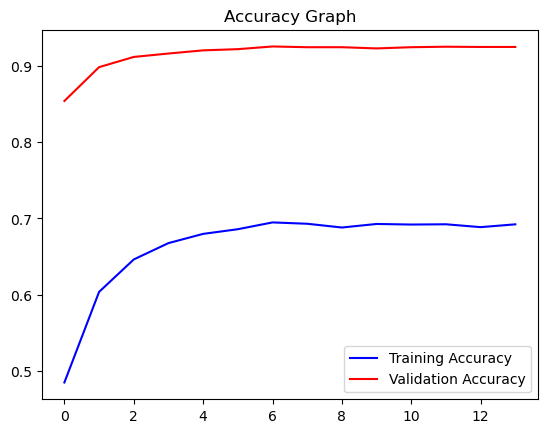

<Figure size 640x480 with 0 Axes>

In [34]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

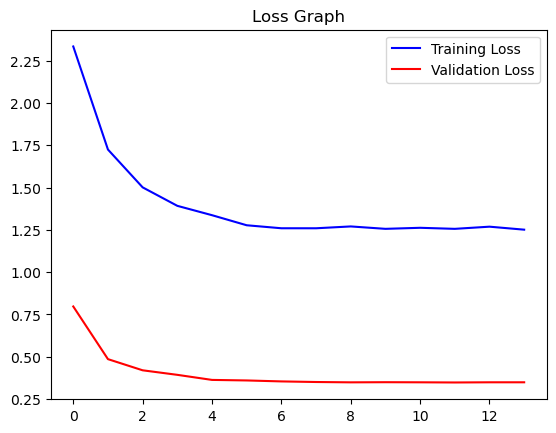

In [35]:
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Generating Predictions

1/1 [==============================] - 3s 3s/step


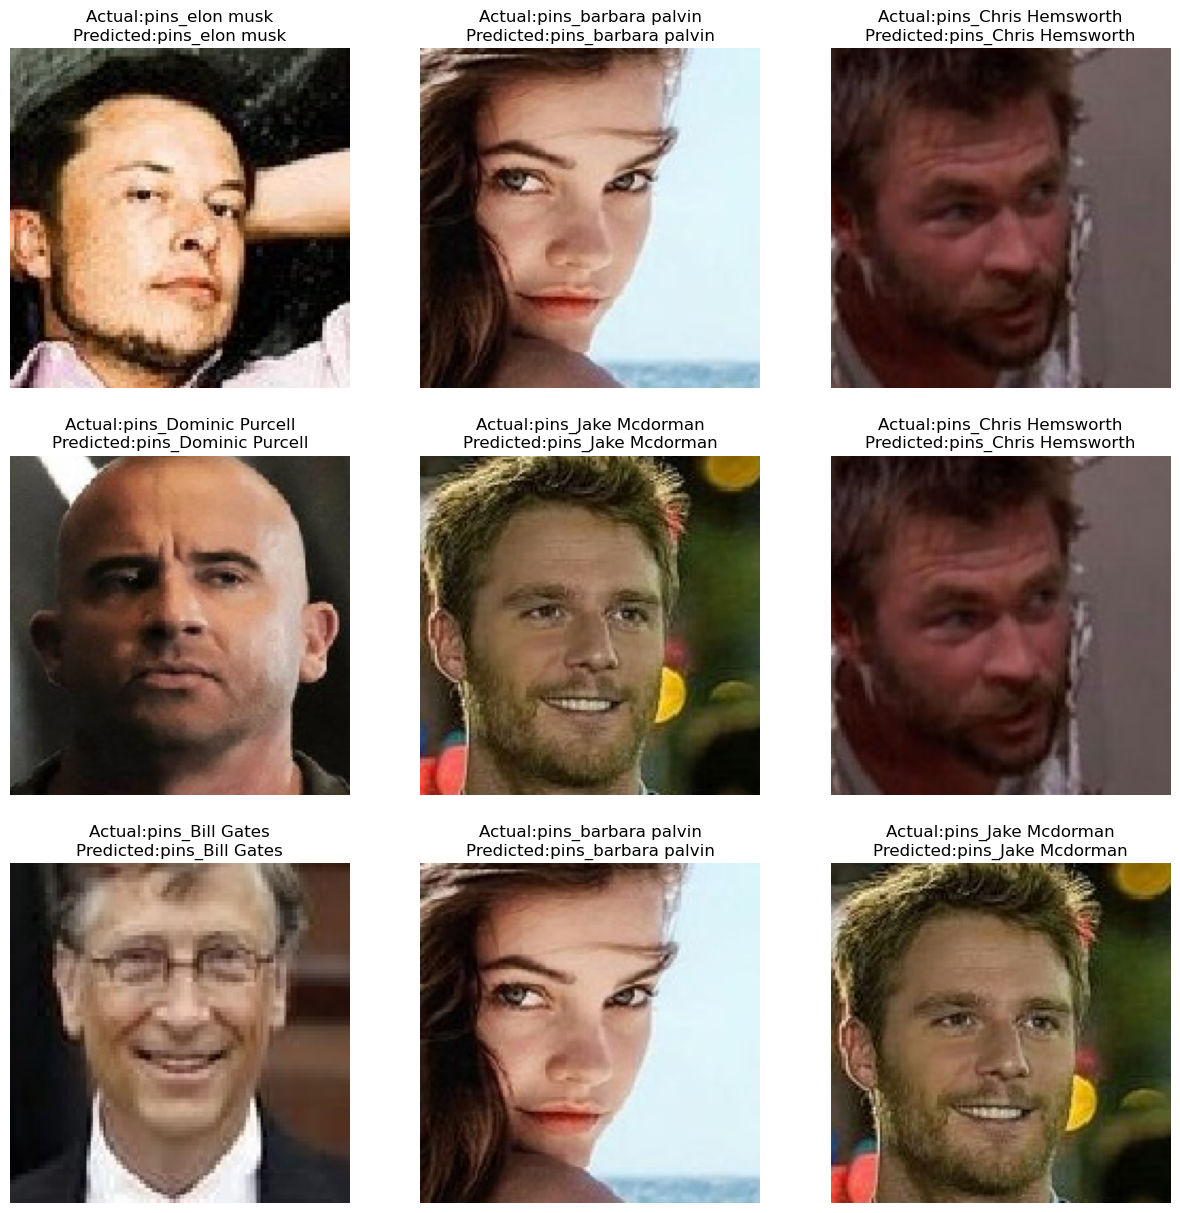

In [36]:
# Get a batch of images and labels
batch_images, batch_labels = next(test_generator)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

predictions = model.predict(batch_images)

# Display images with labels
plt.figure(figsize=(15, 15))
for n , i in enumerate(list(np.random.randint(0,len(batch_images),9))):
    plt.subplot(3, 3, n + 1)
    plt.imshow(batch_images[i])
    plt.title('Actual:'+class_labels[np.argmax(batch_labels[i])]+'\nPredicted:'+class_labels[np.argmax(predictions[i])])  # Display the class label
    plt.axis('off')
plt.show()

In [32]:
# Save the model
model.save("trained_model.h5")  # Save in HDF5 format

## Method 2:
<h3>(Finding similarity between the embeddings generated from the model)

Importing required libraries

In [106]:
# For directory information
import os
from glob import glob

# Progress bars
from tqdm import tqdm

# Processing images
import cv2
import numpy as np

# Visualising images
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Model
from tensorflow.keras.models import load_model

Loading data

In [107]:
root_dir = r'/kaggle/input/pins-face-recognition/105_classes_pins_dataset'
dirs = os.listdir(root_dir)

Splitting data into training and testing

In [108]:
# Taking 30 images per person as training data
X_train_paths = [img  for dir in dirs for img in glob(os.path.join(root_dir, dir, '*'))[:30]]
y_train = [dir  for dir in dirs for img in glob(os.path.join(root_dir, dir, '*'))[:30]]

In [109]:
# Taking 20 images per person as testing data
X_test_paths = [img  for dir in dirs for img in glob(os.path.join(root_dir, dir, '*'))[30:51]]
y_test = [dir  for dir in dirs for img in glob(os.path.join(root_dir, dir, '*'))[30:51]]

Image Preprocessing

In [110]:
# Default size
img_size = (160,160,3)

In [111]:
# Creating an array to store processed training images
X_train = np.empty(shape=(len(X_train_paths), img_size[0], img_size[1], img_size[2]))

for i, image_path in enumerate(X_train_paths):
    try:
      image = cv2.imread(image_path)
      if image is not None:
        resized_img = cv2.resize(image, (img_size[0],img_size[1])) 
        # Normalising images
        norm_img = resized_img.astype(np.float32) / 255.0 
        X_train[i] = norm_img
      else:
        print(f"{filename}: Error reading image (empty).")
    except (cv2.error, FileNotFoundError) as e:
      print(f"{filename}: Error verifying image - {e}")

In [112]:
# Creating an array to store processed testing images
X_test = np.empty(shape=(len(X_test_paths), img_size[0], img_size[1], img_size[2]))

for i, image_path in enumerate(X_test_paths):
    try:
      image = cv2.imread(image_path)
      if image is not None:
        resized_img = cv2.resize(image, (img_size[0],img_size[1]))
        norm_img = resized_img.astype(np.float32) / 255.0
        X_test[i] = norm_img
      else:
        print(f"{filename}: Error reading image (empty).")
    except (cv2.error, FileNotFoundError) as e:
      print(f"{filename}: Error verifying image - {e}")

Displaying images

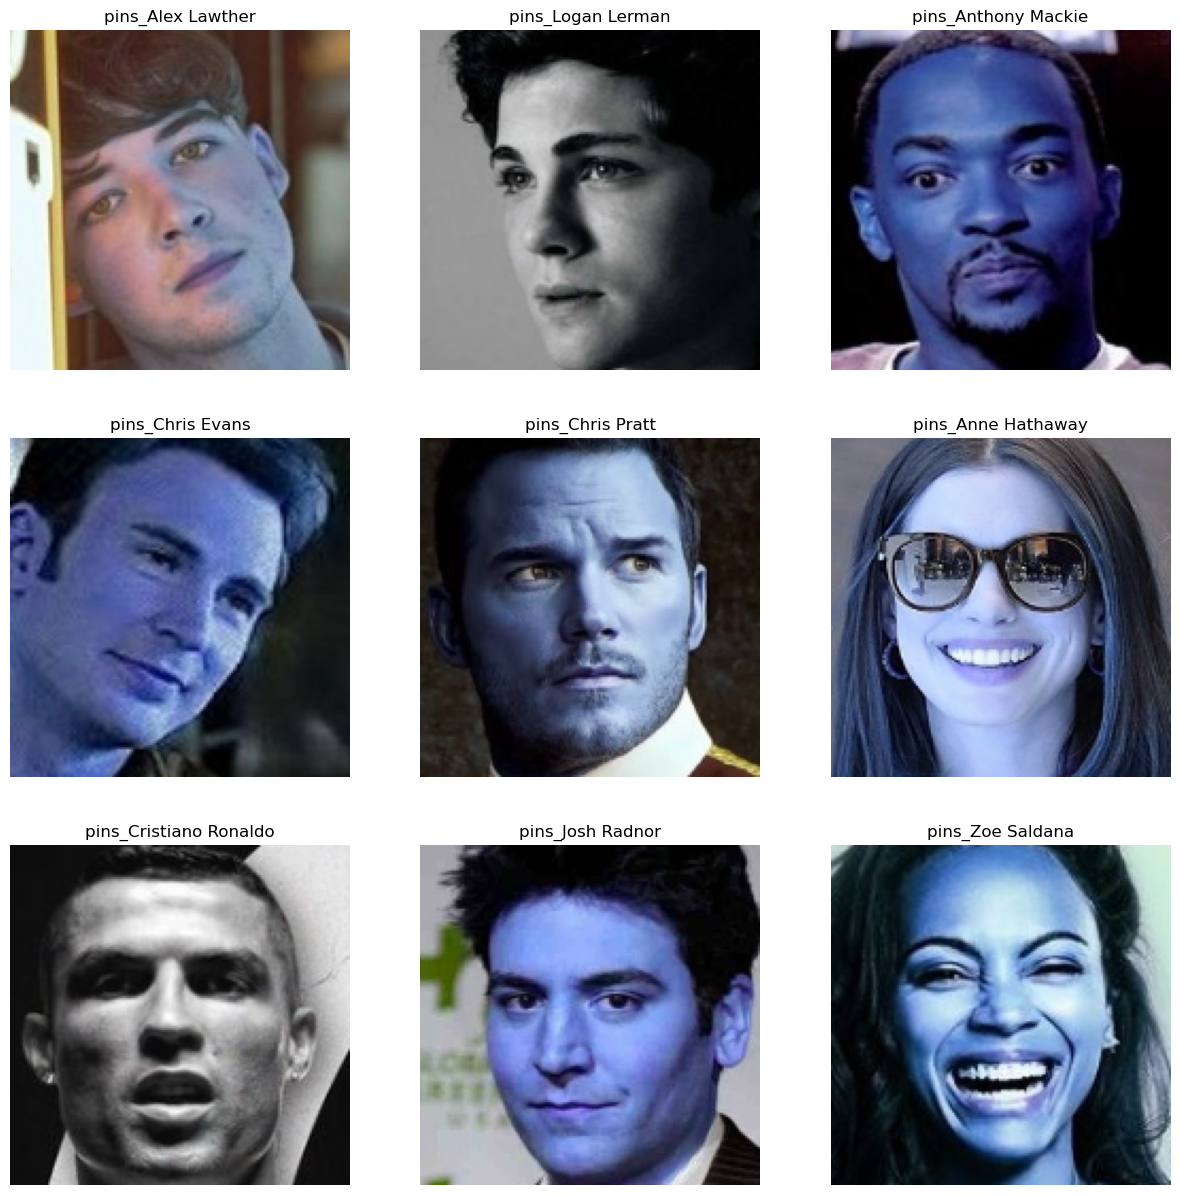

In [113]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[50*i])
    plt.title(y_train[50*i])  # Display the class label
    plt.axis('off')
plt.show()

Loading the model

In [114]:
# Using pretrained model
model = load_model('/kaggle/input/facenet-keras/facenet_keras.h5')

In [115]:
# model.summary()

In [116]:
# # If you are using custom image size run this cell
# from keras.models import Model
# from keras.layers import Input

# # Load your pretrained model
# model = ...
# # Create a new input layer with the desired input size
# new_input = Input(shape=(..., ..., 3))

# # Use the new input to build a new model
# new_output = model(new_input)
# new_model = Model(new_input, new_output)

In [117]:
# # Change the output layer according to the task
# output_layer = tf.keras.layers...  # Output layer
# model = tf.keras.Model(inputs=..., outputs=output_layer)

Generating embeddings from the model

In [118]:
embeddings = np.empty(shape=(len(X_train_paths), 128))
for i, image_path in tqdm(enumerate(X_train_paths)):
    # Model returns a feature embeddings vector of size (128)
    embeddings[i] = model.predict(X_train[i][np.newaxis])
    # Clears the output screen
    clear_output()
embeddings.shape

3150it [04:17, 12.23it/s]


(3150, 128)

Finding the average of embeddings of same person to produce more generalised results

In [119]:
#Store these embeddings in a database to compare new embeddings against them
# Averaging the 30 embeddings of each person
averaged_embeddings = embeddings.reshape(105, 30, 128).mean(axis=1)
averaged_embeddings.shape

(105, 128)

Predicting classes

In [120]:
def predict_class(img):
    img_emb = model.predict(img[np.newaxis])
    # Array to store the embedding distance b/w the target image and the database of images
    temp = np.empty(shape=(105))
    for i, emb in enumerate(averaged_embeddings):
        # Calculating embedding distance
        embedding_distance = emb-img_emb
        # L2 normalization
        embedding_distance_norm = np.linalg.norm(embedding_distance)
        temp[i] = embedding_distance_norm
    # Finding the image which is similar to the target
    label_index = temp.argmin()
    return dirs[label_index]

In [121]:
# Predicting labels for the testing images
y_pred = []
for img in tqdm(X_test):
    y_pred.append(predict_class(img))
    clear_output()

100%|██████████| 2205/2205 [03:03<00:00, 12.00it/s]


Displaying images with predicted labels

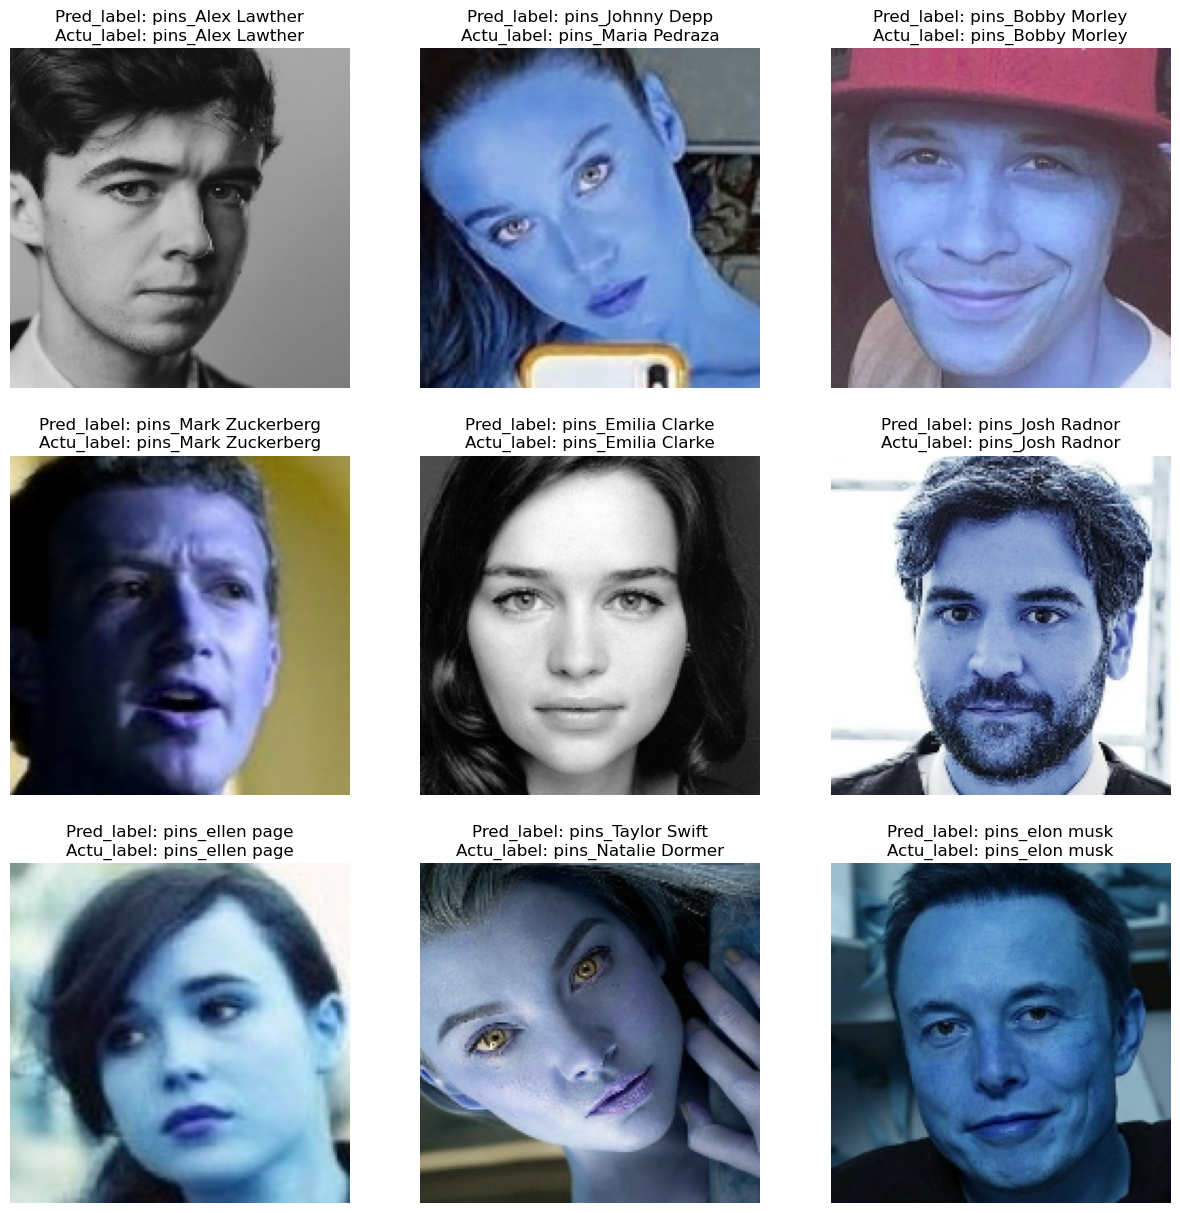

In [122]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[50*i])
    plt.title('Pred_label: '+y_pred[50*i]+'\nActu_label: '+y_test[50*i])  # Display the class label
    plt.axis('off')
plt.show()

Calculating Accuracy 

In [123]:
correct = 0

for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        correct = correct+1
print('Accuracy =',(correct/len(y_test))*100)

Accuracy = 88.16326530612245


Achieved 90%+ accuracy by just using the pretrained model. You can train the model using the complete dataset to increase the accuracy. Manually selecting the images for the database which best represents the images in various conditions make the model more efficient

There are different models like vgg-16, resnet, xception etc., for image classification. You can customize and use them according to your task.

In [ ]:
#Dataset used: pins-face-recognition
#Model used: facenet-keras